# OAK-D ARRANGE
After converting the raw dataset into .mp4 format using the `OAKpreprocessing.py` scrip. It is necessary to split the video sequences, perform silhouette segmentation (background substraction) and train a classificator 
In this scrip performs the following tasks:
- Split the .mp4 videos into single walking sequences.
- 

In [28]:
import cv2
import os
import shutil
import colorsys
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from glob import glob

Let's define some helping functions for the next secctions

In [7]:
def findLimits(frame):
    ''' Let's find the red objects in the scene ''' 
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    h,_,_ = cv2.split(hsv_frame)
    lower_red = np.array([0,150,150])
    upper_red = np.array([20,255,255])
    red = cv2.inRange(hsv_frame, lower_red, upper_red)
    red = cv2.bitwise_not(red)
    
    # Finding the possition of the two red marks in the scene
    keypoints = detector2.detect(red)
    marks = []
    copied_im = cv2.cvtColor(red.copy(), cv2.COLOR_GRAY2BGR)
    for k in keypoints:
        x, y = k.pt
        marks.append((int(x), int(y)))
    return marks

def isEmpty(scene):
    ''' Checks if in the current frame there is someone using the histogram of a blank laboratory '''
    hsv_scene = cv2.cvtColor(scene,cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv_scene)
    H_array = H[S > 100].flatten()
    val, pos = np.histogram(H_array, 18)
    val[[0,3]] = 0
#     print(val[[4,5,7,8,12,13,14,15,16]].max())
    return val.max()<1000

def create_dir(folder, force=True, verbose=False):
    '''   Create a directory if it doesn't exist  '''
    try:
        os.makedirs(folder)
        if verbose: print('Directory {} created succesfully.'.format(folder))   
    except:
        if force:
            if verbose: print('{} already exists. Creating a new one'.format(folder))
            shutil.rmtree(folder)
            os.makedirs(folder)
        else:
            if verbose: print('{} already exists.'.format(folder))
            pass

def bkgrd_hsv_substraction(frgrd, bkgrd):
    ''' Performs background substraction using the HLS color space '''
    bkgrd_hsv = cv2.cvtColor(bkgrd, cv2.COLOR_BGR2HLS)
    frgrd_hsv = cv2.cvtColor(frgrd, cv2.COLOR_BGR2HLS)

    diff = cv2.subtract(bkgrd_hsv, frgrd_hsv)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, raw = cv2.threshold(diff_gray, 15, 255, cv2.THRESH_BINARY)
    if diff_gray.sum()> 400000:
        closed = fine_mask(raw)
        blured = cv2.GaussianBlur(closed,(3,3),0)
        return True, raw, closed, blured
    else:
        return False, None, None, None

def isBackground(frgnd, bkgnd, th=1):
    bkgrd_hsv = cv2.cvtColor(bkgnd, cv2.COLOR_BGR2Lab)
    frgrd_hsv = cv2.cvtColor(frgnd, cv2.COLOR_BGR2Lab)

    diff = cv2.subtract(bkgrd_hsv, frgrd_hsv)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    return diff.sum() / 1000000

def com_his(frame, background, th=5):
    hsv_scene = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv_scene)
    H_array = H[S > 100].flatten()
    val1, pos = np.histogram(H_array, 18)
#     print(val1)

    hsv_scene = cv2.cvtColor(background,cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv_scene)
    H_array = H[S > 100].flatten()
    val2, pos = np.histogram(H_array, 18)
#     print(val2)
    return np.linalg.norm(val2 - val1) //1000 > th

kernel = np.ones((5,5),np.uint8)
def bkgrd_Lab_substraction(frame, background, th=5):
    ''' Performs background substraction using the Lab color space, which helps to reduce light noise '''
    bkgrd_h = (cv2.cvtColor(background, cv2.COLOR_BGR2Lab))
    frgrd_h = (cv2.cvtColor(frame, cv2.COLOR_BGR2Lab))

    diff = cv2.subtract(bkgrd_h, frgrd_h)
    diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, diff = cv2.threshold(diff, 5, 255, cv2.THRESH_BINARY)
    diff = cv2.morphologyEx(diff, cv2.MORPH_CLOSE, kernel)
    if diff.sum() / 1000000 > th:
        closed = fine_mask(diff)
        blured = cv2.GaussianBlur(closed,(3,3),0)
        closed = cv2.multiply(diff, closed)
        return True, diff, closed, blured
    else:
        return False, None, None, None
    
def fine_mask(mask):
    ''' Takes a raw mask as input and returns the biggest contour mask '''
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    c = max(contours, key = cv2.contourArea)
    out = np.zeros_like(mask)
    out = cv2.drawContours(out, [c], 0, 255, -1)
    return out


def random_colors(N, bright=True):
    ''' Generate random colors  '''
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    # random.shuffle(colors)
    return colors

color = random_colors(1)[0]

def apply_mask(frame, mask, color, alpha=0.5):
    ''' Apply the given mask to the image '''
    image = frame.copy()
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

## 1. Split the videos into single walking sequences
In this step we compare the background with each frame to split the large videos

In [8]:
clips_directory = '/home/israel/Downloads/OAKD_8S/clips'
raw_directory = '/home/israel/Downloads/OAKD_8S/color/'
subjects = sorted(os.listdir(os.path.join(raw_directory, '090')))
np.array(subjects[1:])

array(['001', '002', '003', '004', '005', '006', '007'], dtype='<U3')

In [9]:
views = ['120']
walks = {'nm':'nm.mp4', 'bg':'bg.mp4', 'cl':'cl.mp4'}
# walks = {'cl':'cl.mp4'}
# walks = {'nm':'nm.mp4'}
# walks = {'bg':'bg.mp4'}

In [6]:
subject_new = False   # Creates a new directory for each subject [001, ... , ]
walk_new = True       # Creates a new directory for each walking [nm, bg, cl]
empty_frame = 90    # True if the first frame is background
already_background = False
for view in views:
    print(f'PROCESSING VIEW: {view}')
#     for subject in ['006', '007']:
    for subject in subjects:
        for walk, file in walks.items():
            print(f'Processing subject:{subject} walking: {walk} view: {view}')
            video_path = os.path.join(raw_directory, view, subject, file)
            cap = cv2.VideoCapture(video_path)
#             wait = int(1000 / cap.get(cv2.CAP_PROP_FPS))

            sub_dir = os.path.join(clips_directory, view, str(subject).zfill(3))
            create_dir(sub_dir, force=subject_new)

            clip_dir = os.path.join(clips_directory, view, str(subject).zfill(3), walk)
            create_dir(clip_dir, force=walk_new)

            # Identify the background of each sequence using the 'isEmpty()' function
            cnt = 0
            background = None

            while True:
                ret, first = cap.read()
                if ret:
                    if cnt == empty_frame:
                        background = first
                        break
                    cnt+=1
                else:
                    print('Not background fount')
                    break
            # Saving the background image
            back_name = os.path.join(clip_dir, f'background.png')
            cv2.imwrite(back_name, background)

            # Defining parameters to split each video
            cap.set(cv2.CAP_PROP_POS_FRAMES, 90)
            cnt = 0
            nwalking = 1
            isWalking = False
            x = deque(12*[True],12)

            # Getting parameters for the video clips
            codec = cv2.VideoWriter_fourcc('M','J','P','G')
            fwidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            fheight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = int(cap.get(cv2.CAP_PROP_FPS))

            while True:
                ret, scene = cap.read()
                if ret:
                    if cnt%3 == 0:
                        diff,_,_,_ = bkgrd_Lab_substraction(scene, background, th=15)
#                         diff = com_his(scene, background, th=15)
#                         cv2.putText(scene, str(diff), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)

                        x.appendleft(not diff) 
#                         if np.mean(np.array([x[1], x[2], x[3], x[4], x[5], x[6]])) > 0.8:
                        if np.average(x)>0.7:
                            if isWalking:
                                print(f'|')
                                isWalking = False
                                out.release()
                        elif not isWalking:
                            print(f'Sequence {nwalking}', end='')
                            isWalking = True
                            clip_name = os.path.join(clip_dir, f'{walk}-{str(nwalking).zfill(2)}.avi')
                            out = cv2.VideoWriter(clip_name, codec, fps, (fwidth,fheight))
                            nwalking +=1
                    if isWalking:
                        out.write(scene)
                        if cnt%10==0: print('.', end='')
                    cnt+=1         
#                     cv2.imshow(f'Subject {subject}', scene)
                else:
                    break
                if cv2.waitKey(1) == ord('q'):
                    break
            out.release()
            cap.release()
            cv2.destroyAllWindows()

PROCESSING VIEW: 120
Processing subject:000 walking: nm view: 120


NameError: name 'create_dir' is not defined

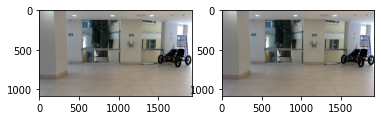

In [112]:
cap = cv2.VideoCapture('/home/israel/Downloads/OAKD_8S/color/090/000/nm.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 100)
ret, frame = cap.read()
plt.subplot(121); plt.imshow(background[:,:,::-1])
plt.subplot(122); plt.imshow(frame[:,:,::-1])

## 2. Background Subtraction
Using the video clips splited in the previus steps, we perform a simple background subtractions to obtain the silhouettes

In [41]:
images_dir = '/home/israel/Downloads/OAKD_8S/frames/'
frs_dir = 'rgb/'
mks_dir = 'masks/'
verbose = True
subjects = ['001', '002', '003', '004', '005', '007']
nclips = {'nm':6, 'bg':4, 'cl':4}

In [42]:
views = ['105', '120']
for view in views:
    frames_dir = os.path.join(images_dir, view, frs_dir)
    masks_dir = os.path.join(images_dir, view, mks_dir)
    print(f'PROCESSING VIEW: {view}')
#     subjects = sorted(os.listdir(os.path.join(clips_directory, view)))
    for subject in subjects:
#     for subject in ['004']:
        print(f'Processing subject: {subject} view: {view}....                                  ')
        create_dir(os.path.join(frames_dir, subject), force=True)
        create_dir(os.path.join(masks_dir, subject), force=True)

        subject_dir = os.path.join(clips_directory, view, subject)
        walks = os.listdir(subject_dir)
        
        for j, walk in enumerate(['nm', 'bg', 'cl']):
#         for j, walk in enumerate(['nm']):

            walk_dir = os.path.join(subject_dir, walk)
            background = cv2.imread(os.path.join(walk_dir, f'background.png'))
            clips = sorted(os.listdir(walk_dir))
            
            save_back_path = os.path.join(frames_dir, subject, f'{walk}-background.png')
            cv2.imwrite(save_back_path, background)
            
            for i, clip in enumerate(clips):
                if clip[-4:] == '.avi' and nclips[walk]>=i:
                    clip_path = os.path.join(walk_dir, clip)
                    sub_dir = os.path.join(frames_dir, subject, walk, clip.split('.')[0])
                    mask_dir = os.path.join(masks_dir, subject, walk, clip.split('.')[0])
                    create_dir(sub_dir, force=True)
                    create_dir(mask_dir, force=True)
                    print(sub_dir, end='\r')
                    cap = cv2.VideoCapture(clip_path)
                    cnt = 0
                    while True:
                        ret, frame = cap.read()
                        if ret:
                            ok, diff_gray, closed, blured = bkgrd_Lab_substraction(frame, background)
                            if ok:
                                cnt +=1
                                frame_path = f'{sub_dir}/{str(cnt).zfill(4)}.png'
                                mask_path = f'{mask_dir}/{str(cnt).zfill(4)}.png'
                                frame = cv2.resize(frame, (0,0), fx=0.5, fy=0.5)
                                closed = cv2.resize(closed, (0,0), fx=0.5, fy=0.5)
                                cv2.imwrite(frame_path, frame)
                                cv2.imwrite(mask_path, closed)
                                if verbose:
                                    masked = apply_mask(frame.copy(), closed.astype('bool'), color)
#                                     cv2.imshow('frame', masked)
                        else:
                            break
                        if cv2.waitKey(1) == ord('q'):
                            break
                    cap.release()
    print('', end="\r")
cv2.destroyAllWindows()

PROCESSING VIEW: 105
Processing subject: 001 view: 105....                                  
Processing subject: 002 view: 105....                                  
Processing subject: 003 view: 105....                                  
Processing subject: 004 view: 105....                                  
Processing subject: 005 view: 105....                                  
Processing subject: 007 view: 105....                                  
PROCESSING VIEW: 120ds/OAKD_8S/frames/105/rgb/007/cl/cl-04
Processing subject: 001 view: 120....                                  
Processing subject: 002 view: 120....                                  
Processing subject: 003 view: 120....                                  
Processing subject: 004 view: 120....                                  
Processing subject: 005 view: 120....                                  
Processing subject: 007 view: 120....                                  
/home/israel/Downloads/OAKD_8S/frames/120/rgb/007/cl/cl-

### Visualization
Let's visualize the results and masking a single frame of each sequence

SHOWING VIEW: 105
Showing subject: 001 view: 105


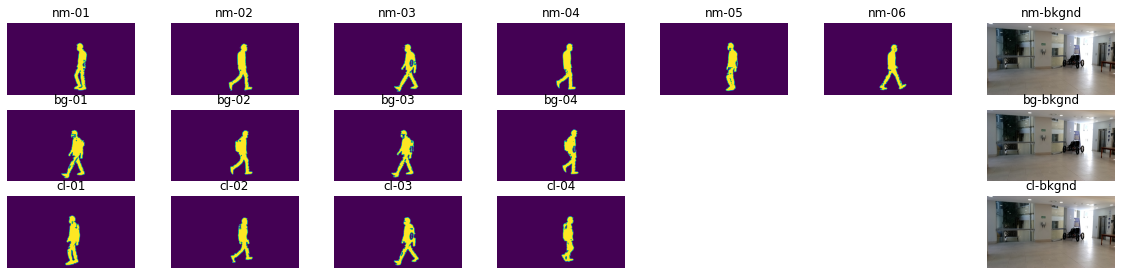

Showing subject: 002 view: 105


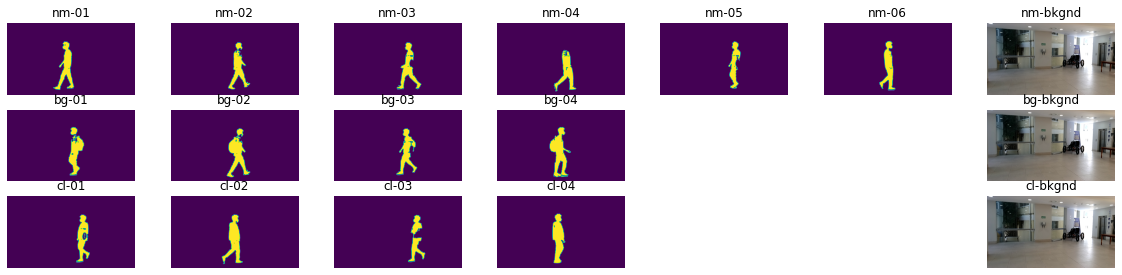

Showing subject: 003 view: 105


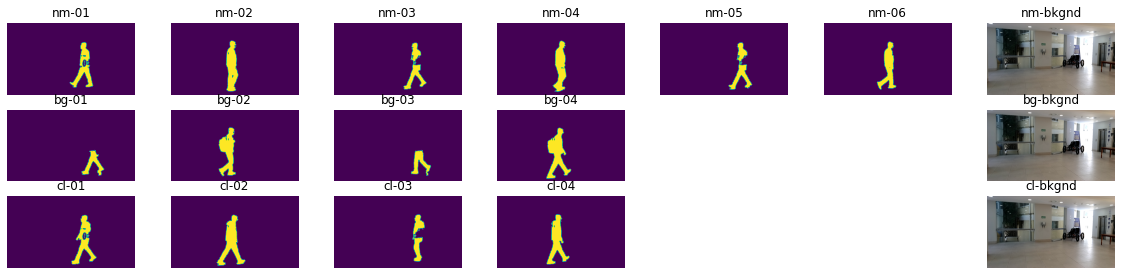

Showing subject: 004 view: 105


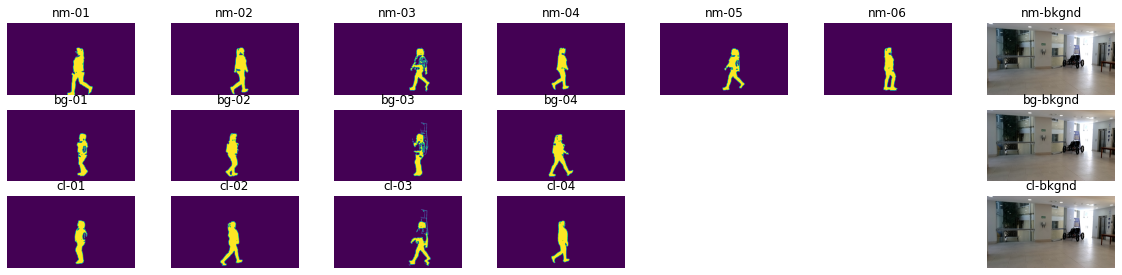

Showing subject: 005 view: 105


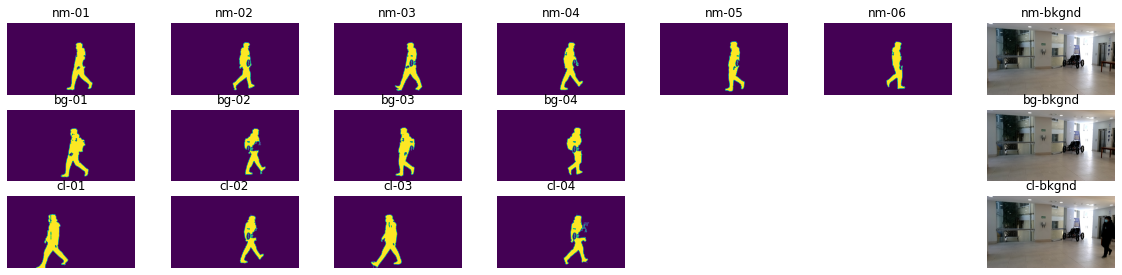

Showing subject: 007 view: 105


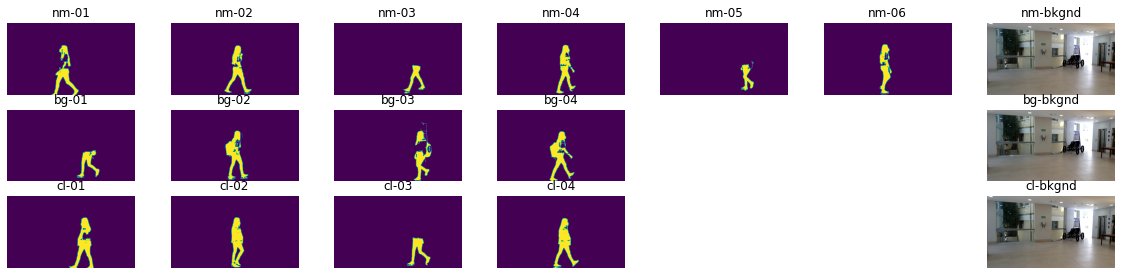

SHOWING VIEW: 120
Showing subject: 001 view: 120


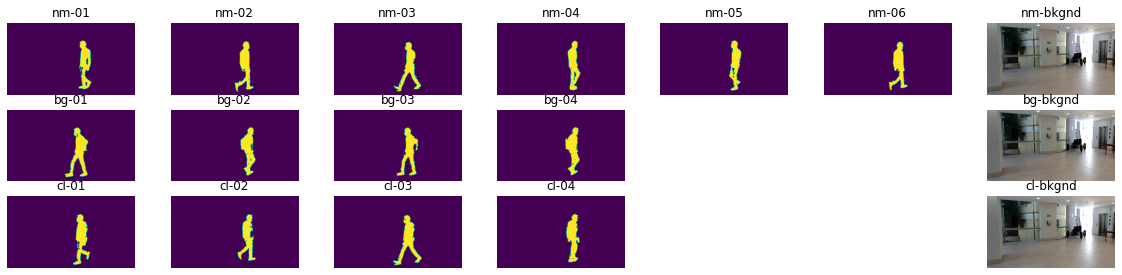

Showing subject: 002 view: 120


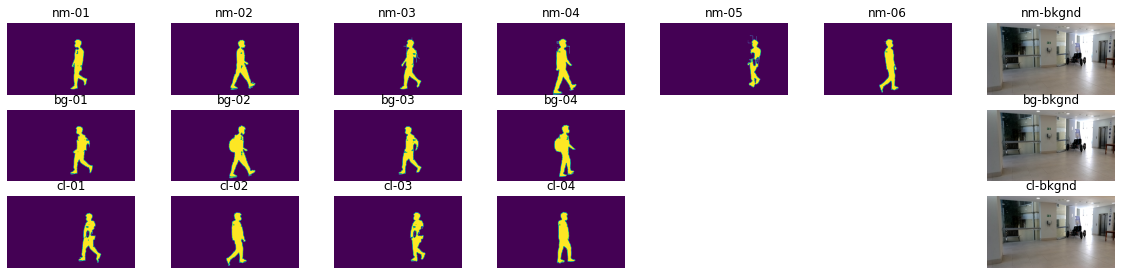

Showing subject: 003 view: 120


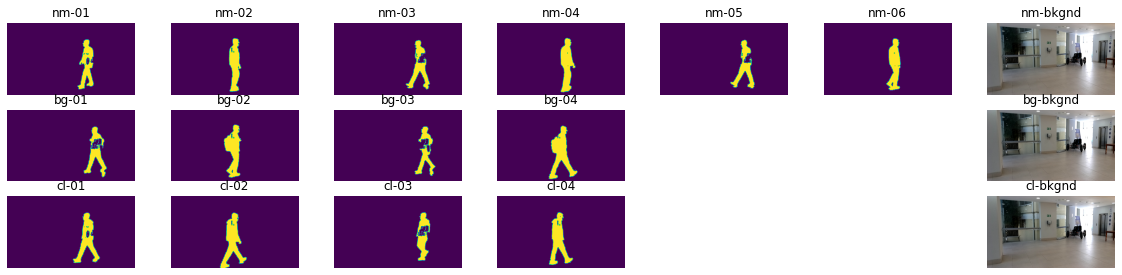

Showing subject: 004 view: 120


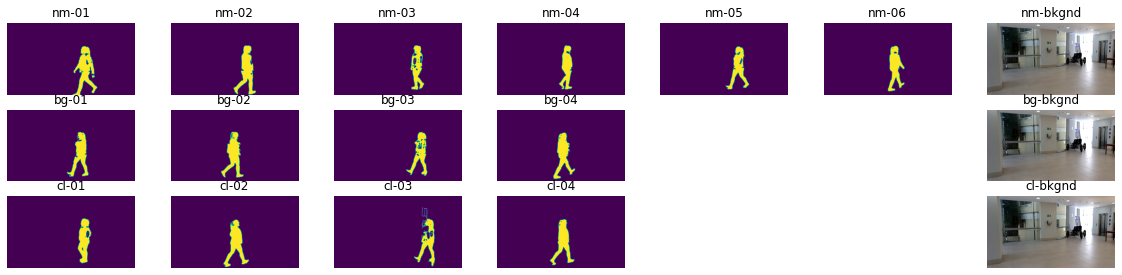

Showing subject: 005 view: 120


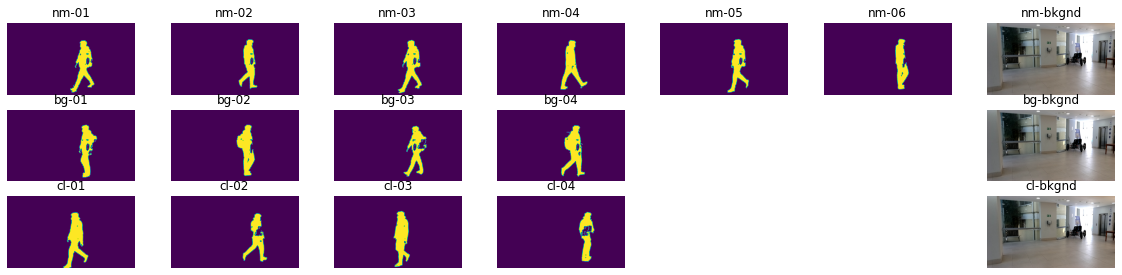

Showing subject: 007 view: 120


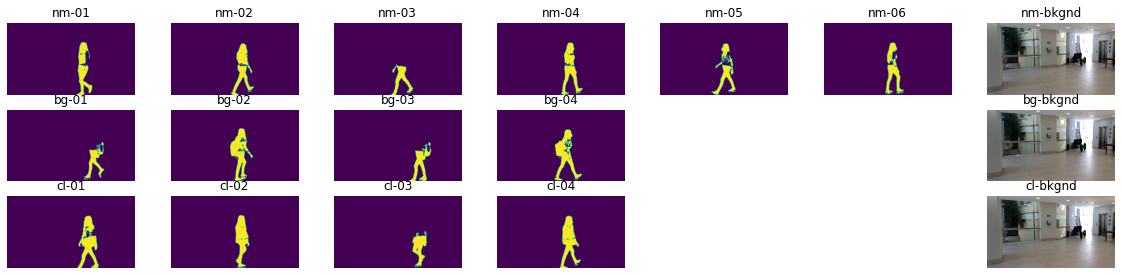

In [43]:
for view in views:
    frames_dir = os.path.join(images_dir, view, frs_dir)
    masks_dir = os.path.join(images_dir, view, mks_dir)
    print(f'SHOWING VIEW: {view}')
    subjects = sorted(os.listdir(frames_dir))
    for subject in subjects:
#     for subject in ['023']:
        print(f'Showing subject: {subject} view: {view}')

        plt.figure(figsize=(20, 4.5))
#         plt.subplots_adjust(wspace=0.1, hspace=0.01)
        for j, walk in enumerate(['nm', 'bg', 'cl']):
#         for j, walk in enumerate(['nm']):

            nplot = j*7 + 1
            rseqs_dir = os.path.join(frames_dir, subject, walk)
            mseqs_dir = os.path.join(masks_dir, subject, walk)
            
            seqs = sorted(os.listdir(rseqs_dir))
            bkgnd_path = os.path.join(frames_dir, subject, f'{walk}-background.png')
#             print(bkgnd_path)
            bkgnd = cv2.imread(bkgnd_path)
            plt.subplot(3, 7, 7*(j+1)); plt.imshow(bkgnd[:,:,::-1]); plt.title(f'{walk}-bkgnd'); plt.axis('off')
            for i, seq in enumerate(seqs):
                try:
    #                 rgb = cv2.imread(os.path.join(rseqs_dir, seq, f'{str(40).zfill(4)}.png'))
                    msk = cv2.imread(os.path.join(mseqs_dir, seq, f'{str(40).zfill(4)}.png'), 0)
    #                 plt.subplot(3, 7, nplot); plt.imshow(msk[:,:,::-1]); plt.title(seq); plt.axis('off')
                    plt.subplot(3, 7, nplot); plt.imshow(msk); plt.title(seq); plt.axis('off')
                except:
                    print(f'Error opening')
                nplot+=1
        plt.show()

## 3. GEI Generation
In this section we perform background subtaction using the video clips generated in the last step as well as the background image

In [54]:
def GEI_generator(sil_file, size = 64,debug = False):
    lfiles = sorted(os.listdir(sil_file))
    stack_GEI = []
    if debug:
        print(f'Number of images: {len(lfiles)}')
        plt.figure(figsize=(20,int(len(lfiles)/10)))
    for idimg, path in enumerate(lfiles):
        if debug: 
            plt.subplot((len(lfiles)//15)+1,15, idimg+1)
        img = cv2.imread(os.path.join(sil_file, path), 0)
        # Silhouette extraction
        if img.mean() > 2:
            x, y, w, h = cv2.boundingRect(img)
            silhouette = img[y:y+h,x:x+w]

            # Normalizae silhouette
            factor = size/max(silhouette.shape)
            height = round(factor*silhouette.shape[0])
            width = round(factor*silhouette.shape[1])
            try:
                if(height>width):
                    nor_sil = cv2.resize(silhouette,(width,height))
                    # We add a background of the shape size x size
                    # We take the upper part of the body to center the image and avoid the legs
                    portion_body = 0.3
                    moments = cv2.moments(nor_sil[0:int(nor_sil.shape[0]*portion_body),])
                    w = round(moments['m10']/moments['m00'])
                    background = np.zeros((size, size))
                    shift = round((size/2)-w)
                    if(shift<0 or shift+nor_sil.shape[1]>size): shift = round((size-nor_sil.shape[1])/2)
                    background[:,shift:nor_sil.shape[1]+shift] = nor_sil

                    stack_GEI.append(background)
                    if debug:
                        plt.imshow(background,'gray'); plt.title(idimg);plt.axis('off')
                        # plt.subplots_adjust(wspace=0.05, hspace=0.01)
            except:
                print(f'Error {os.path.join(sil_file, path)}')
    if stack_GEI == []:
        GEI = np.zeros((size, size))
        print('No Files Found')
        return False, GEI, stack_GEI
    else: 
        GEI = np.mean(np.array(stack_GEI),axis=0)
        return True, GEI, stack_GEI
    

In [55]:
images_dir = '/home/israel/Downloads/OAKD_8S/frames/'
representations_dir = '/home/israel/Downloads/OAKD_8S/representations/'
frs_dir = 'rgb/'
mks_dir = 'masks/'
views = ['075','090','105','120']
verbose = False

In [56]:
for view in views:
    frames_dir = os.path.join(images_dir, view, frs_dir)
    masks_dir = os.path.join(images_dir, view, mks_dir)
    rep_dir = os.path.join(representations_dir, view)
    print(f'GENERATING GAIT REPRESENTATIONS FROM VIEW: {view}')
    subjects = sorted(os.listdir(os.path.join(images_dir, view, frs_dir)))
    for subject in subjects:
#     for subject in ['022', '023', '025']:
        print(f'Processing subject: {subject} view: {view}')
        sub_GEI_dir = os.path.join(rep_dir, subject)
        create_dir(sub_GEI_dir, force=True)

        for j, walk in enumerate(['nm', 'bg', 'cl']):
#         for j, walk in enumerate(['nm']):

            seq_dir = os.path.join(masks_dir, subject, walk)
            seqs = sorted(os.listdir(seq_dir))
            print(f'Processing: {seqs}')
            for s, seq in enumerate(seqs):
                seq_frames_dir = os.path.join(seq_dir, seq)
                ret, GEI, _ = GEI_generator(seq_frames_dir)
                if ret:
                    GEI_name = os.path.join(sub_GEI_dir, f'{walk}-{str(s).zfill(2)}.png')
                    cv2.imwrite(GEI_name, GEI)
                else:
                    break

GENERATING GAIT REPRESENTATIONS FROM VIEW: 075
Processing subject: 001 view: 075
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl-01', 'cl-02', 'cl-03', 'cl-04']
Processing subject: 002 view: 075
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl-01', 'cl-02', 'cl-03', 'cl-04']
Processing subject: 003 view: 075
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl-01', 'cl-02', 'cl-03', 'cl-04']
Processing subject: 004 view: 075
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl-01', 'cl-02', 'cl-03', 'cl-04']
Processing subject: 005 view: 075
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Process

### GEI Visualization

SHOWING VIEW: 075
Showing subject: 001 view: 075


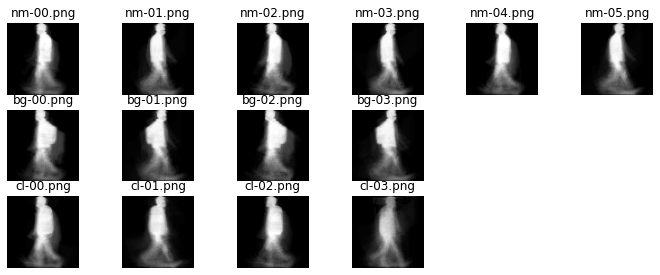

Showing subject: 002 view: 075


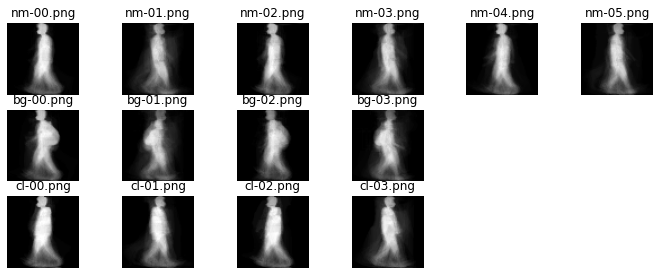

Showing subject: 003 view: 075


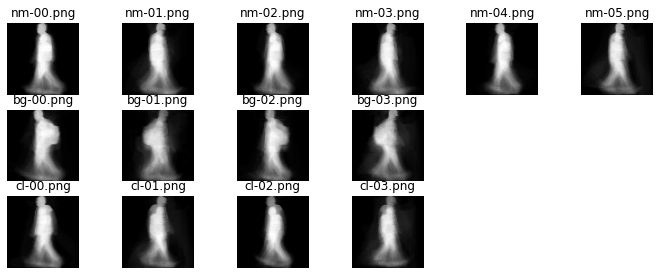

Showing subject: 004 view: 075


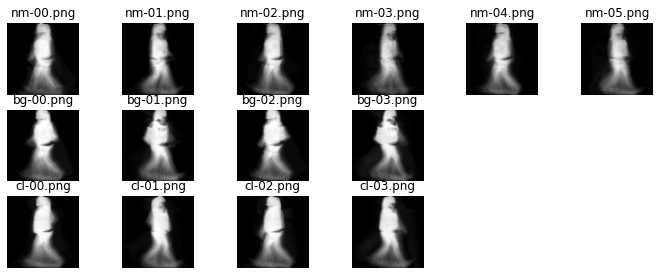

Showing subject: 005 view: 075


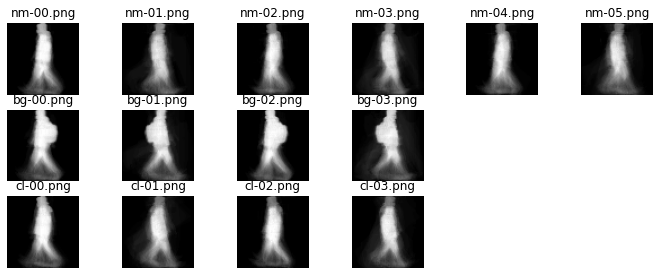

Showing subject: 007 view: 075


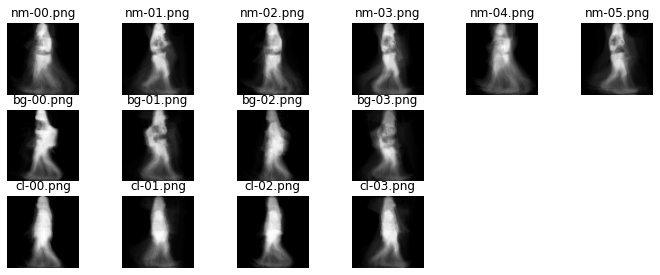

SHOWING VIEW: 090
Showing subject: 001 view: 090


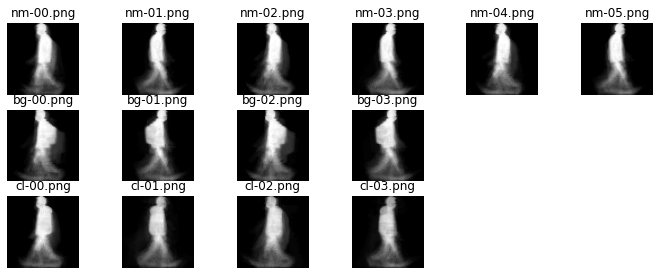

Showing subject: 002 view: 090


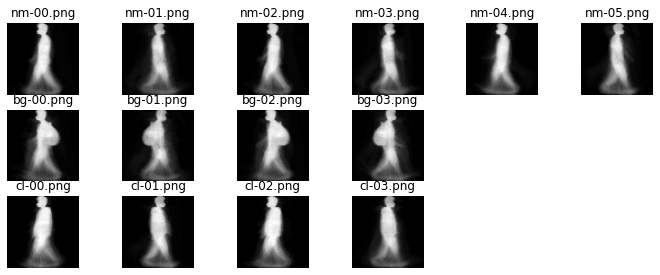

Showing subject: 003 view: 090


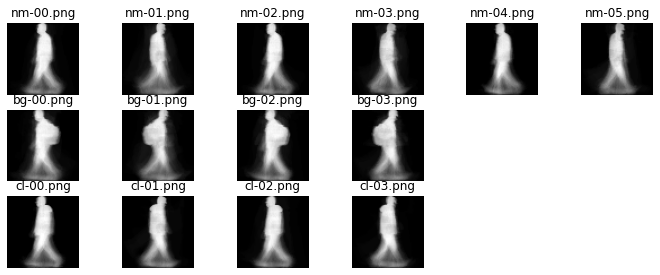

Showing subject: 004 view: 090


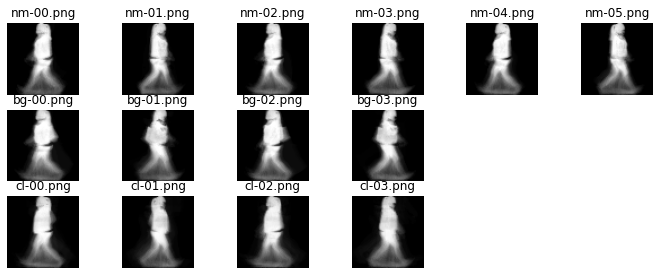

Showing subject: 005 view: 090


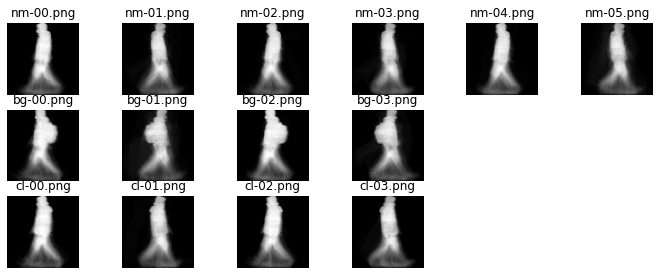

Showing subject: 007 view: 090


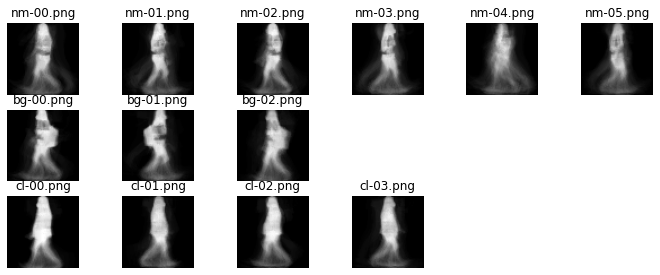

SHOWING VIEW: 105
Showing subject: 001 view: 105


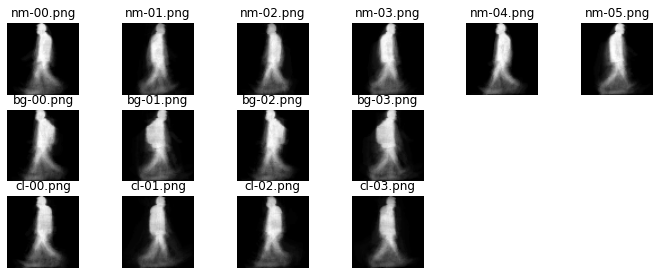

Showing subject: 002 view: 105


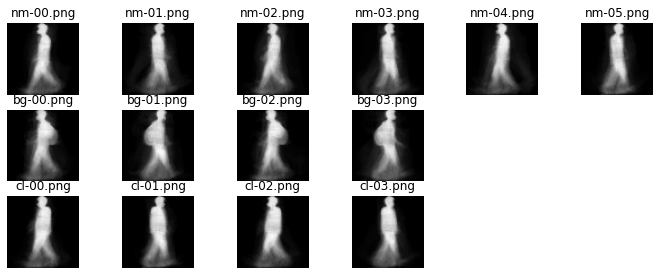

Showing subject: 003 view: 105


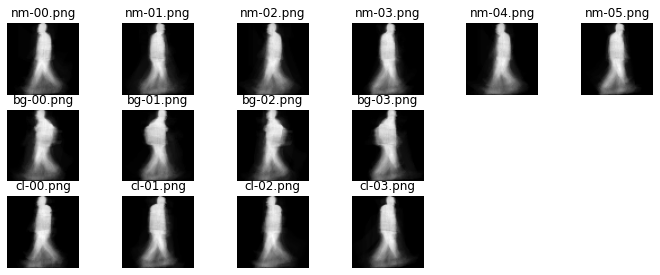

Showing subject: 004 view: 105


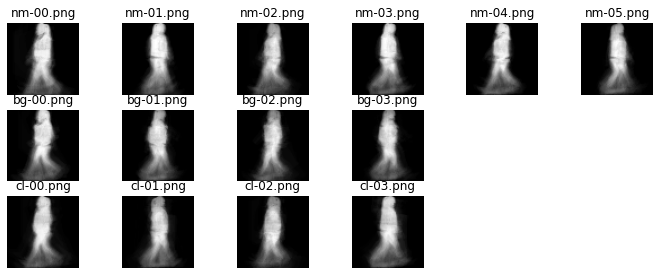

Showing subject: 005 view: 105


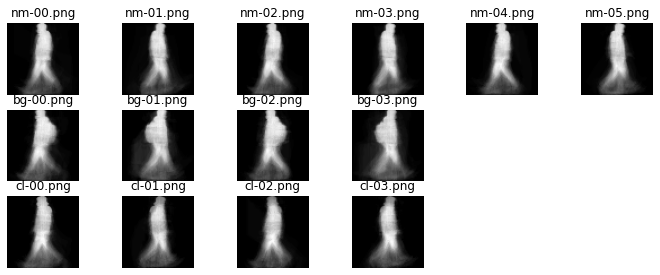

Showing subject: 007 view: 105


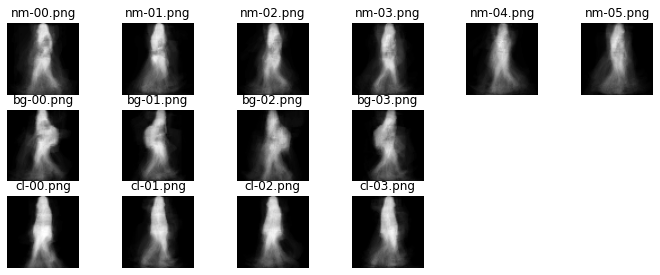

SHOWING VIEW: 120
Showing subject: 001 view: 120


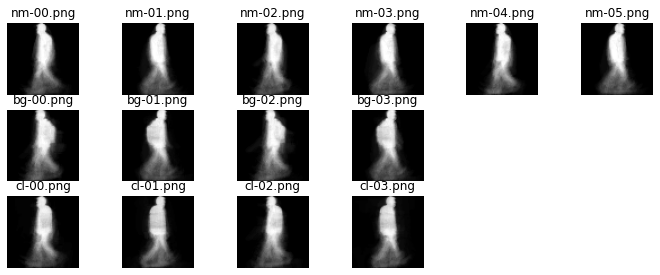

Showing subject: 002 view: 120


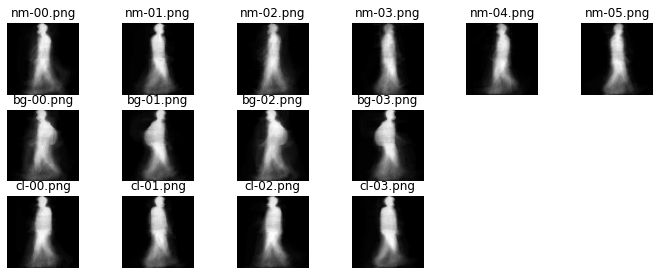

Showing subject: 003 view: 120


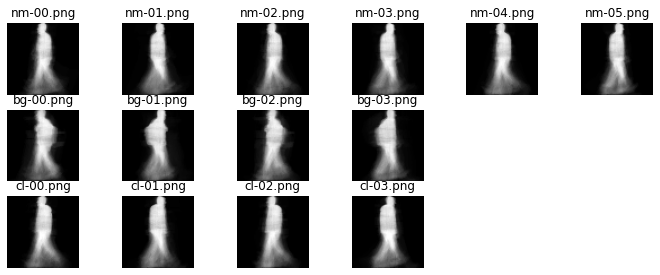

Showing subject: 004 view: 120


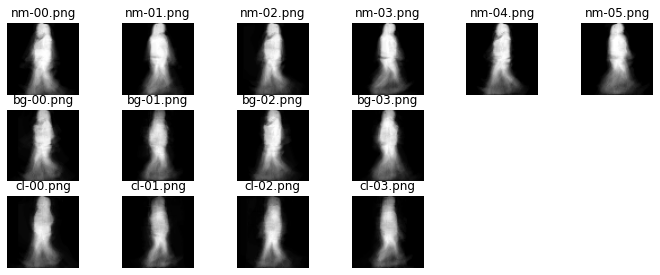

Showing subject: 005 view: 120


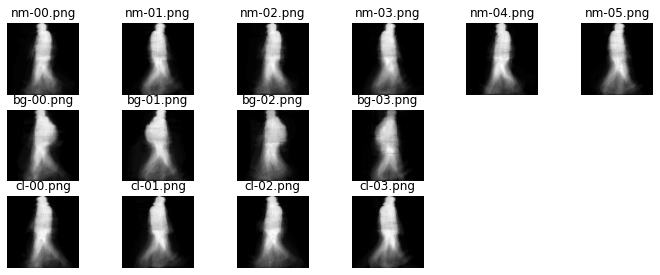

Showing subject: 007 view: 120


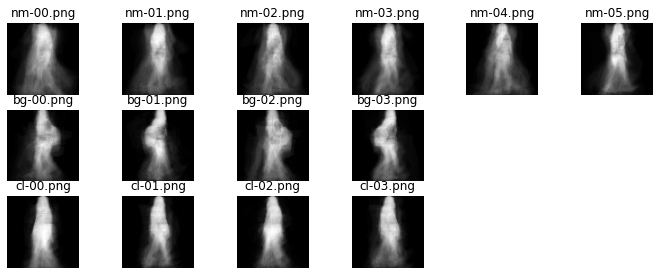

In [57]:
for view in views:
    print(f'SHOWING VIEW: {view}')
    rep_dir = os.path.join(representations_dir, view)
    subjects = sorted(os.listdir(rep_dir))

    for subject in subjects:
#     for subject in ['002']:
        print(f'Showing subject: {subject} view: {view}')
        plt.figure(figsize=(12, 4.5))
#         plt.subplots_adjust(wspace=0.01, hspace=0.01)

        nsec = 1
        for j, walk in enumerate(['nm', 'bg', 'cl']):
            seqs = sorted(glob(os.path.join(representations_dir, view, subject)+f'/{walk}*'))[:nclips[walk]]
            for i, seq in enumerate(seqs):
                GEI = cv2.imread(seq)
                
                plt.subplot(3, 6, j*6+(i+1)); plt.imshow(GEI, 'gray'); plt.title(seq.split('/')[-1]); plt.axis('off')
        plt.show()

## 4. Classification
Using the GEIs generated in the last step, we arrange the data to perform the classification

In [68]:
representations_dir = '/home/israel/Downloads/OAKD_8S/representations/'
frs_dir = 'rgb/'
mks_dir = 'masks/'
verbose = False
views = ['060', '075','090','105','120']


In [69]:
def GEI2MGEI(GEI, fr, to):
    GEI[fr:to]==0
    return GEI

In [79]:
training = {'data':[], 'labels': [], 'seqs':['nm-00', 'nm-01', 'nm-02', 'nm-03', 'cl-00', 'bg-00']}
testing = {'nm':{'data':[], 'labels': [], 'seqs': ['nm-04', 'nm-05']},
           'cl':{'data':[], 'labels': [], 'seqs': ['cl-01', 'cl-02', 'cl-03']},
           'bg':{'data':[], 'labels': [], 'seqs': ['bg-01', 'bg-02', 'bg-03']}}
h, w = 64, 64
fr = int(h * 0.15)
to = int(h * 0.60)
for view in views:
    rep_dir = os.path.join(representations_dir, view)
    print(f'GENERATING GAIT REPRESENTATIONS FROM VIEW: {view}')
    subjects = sorted(os.listdir(rep_dir))
    skip_sub = ['022', '023']
    
    for subject in subjects:
#     for subject in ['001']:
        if subject not in skip_sub:
            print(f'Processing subject: {subject} view: {view}')
            sub_GEI_dir = os.path.join(rep_dir, subject)

            for seq_tr in training['seqs']:
                walk = seq_tr.split('-')[0]
                GEI_name = os.path.join(sub_GEI_dir, f'{seq_tr}.png')
                GEI = GEI2MGEI(cv2.imread(GEI_name, 0),fr,to).flatten()
                training['data'].append(GEI)
                training['labels'].append(int(subject))
    #             print(GEI_name)

            for walk, dic in testing.items():
                for seq_tr in dic['seqs']:
                    GEI_name = os.path.join(sub_GEI_dir, f'{seq_tr}.png')
#                     print(GEI_name, end='\r')
                    GEI = GEI2MGEI(cv2.imread(GEI_name, 0),fr, to).flatten()
                    dic['data'].append(GEI)
                    dic['labels'].append(int(subject))

GENERATING GAIT REPRESENTATIONS FROM VIEW: 060
Processing subject: 001 view: 060
Processing subject: 002 view: 060
Processing subject: 003 view: 060
Processing subject: 004 view: 060
Processing subject: 005 view: 060
Processing subject: 007 view: 060
GENERATING GAIT REPRESENTATIONS FROM VIEW: 075
Processing subject: 001 view: 075
Processing subject: 002 view: 075
Processing subject: 003 view: 075
Processing subject: 004 view: 075
Processing subject: 005 view: 075
Processing subject: 007 view: 075
GENERATING GAIT REPRESENTATIONS FROM VIEW: 090
Processing subject: 001 view: 090
Processing subject: 002 view: 090
Processing subject: 003 view: 090
Processing subject: 004 view: 090
Processing subject: 005 view: 090
Processing subject: 007 view: 090
GENERATING GAIT REPRESENTATIONS FROM VIEW: 105
Processing subject: 001 view: 105
Processing subject: 002 view: 105
Processing subject: 003 view: 105
Processing subject: 004 view: 105
Processing subject: 005 view: 105
Processing subject: 007 view: 

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [81]:
trainX = np.array(training['data'])
trainY = np.array(training['labels'])

# Escalamos los datos
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)

print(f'Training shape: {trainX.shape} | Testing shape {trainY.shape}')

_ ,componentes_original = trainX.shape

# Aplicamos PCA
pre = 0.9999
pca = PCA(pre)
pca.fit(trainX)
componentes_PCA = pca.n_components_
print(f'Com Init : {componentes_original} Comp PCA: {componentes_PCA} Preservando: {pre*100}')
trainX = pca.transform(trainX)

# Declaramos el modelo y lo ajustamos
# logisticRegr = LogisticRegression(solver = 'lbfgs',C=0.1,tol=0.0000001)
# logisticRegr = KNeighborsClassifier(n_neighbors=1)
# logisticRegr = SVC(probability=True)
logisticRegr = LinearDiscriminantAnalysis(solver = 'lsqr',shrinkage=0.2)
logisticRegr.fit(trainX, trainY)


# Calculamos su score
score = logisticRegr.score(trainX, trainY)
print('Dataset: Train',' shape test: ',trainX.shape,' correcto: ',np.round(score,4))
# Realizamos pruebas en los datasets de testeo
# datasets = np.array(['test_nm_','test_bg_','test_cl_'])
for i in ['nm', 'bg', 'cl']:
    testX = np.array(testing[i]['data'])
    testY = np.array(testing[i]['labels'])


    testX = scaler.transform(testX)
    # testX = normalizacion2(testX,mean,st)
    testX = pca.transform(testX)

    # Calculamos su score
    score = logisticRegr.score(testX, testY)
    certeza = logisticRegr.predict(testX)

    # Mostramos la matriz de confusion
    # print(confusion_matrix(certeza,testY))
    print(f'Walking {i} Shape test: {testX.shape} correcto: {np.round(score,4)}')

Training shape: (180, 4096) | Testing shape (180,)
Com Init : 4096 Comp PCA: 178 Preservando: 99.99
Dataset: Train  shape test:  (180, 178)  correcto:  1.0
Walking nm Shape test: (60, 178) correcto: 1.0
Walking bg Shape test: (90, 178) correcto: 0.7
Walking cl Shape test: (90, 178) correcto: 0.8778


In [84]:
from pickle import dump

dump(pca, open('OAKD8S_pca.pkl', 'wb'))
dump(scaler, open('OAKD8S_scaler.pkl', 'wb'))
dump(logisticRegr, open('OAKD8S_model.pkl', 'wb'))